# Gate tune-up and DRAG
Gengyan Zhang, July 16 2016
## References
- Gate tune-up  
    [Quantum Information Processing with Superconducting Qubits](http://rsl.yale.edu/publications/publication/165) (Jerry Chow thesis, section 6.3.2)  
    [Controlling Coherent State Superpositions with Superconducting Circuits](http://rsl.yale.edu/publications/publication/176) (Brian Vlastakis thesis, Appendix A)  
    [Characterizing errors on qubit operations via iterative randomized benchmarking](http://link.aps.org/doi/10.1103/PhysRevA.93.012301)
- Derivative removal via adiabatic gate (DRAG)  
    [Quantum Information Processing with Superconducting Qubits](http://rsl.yale.edu/publications/publication/165) (Jerry Chow thesis, section 6.4)  
    [Simple Pulses for Elimination of Leakage in Weakly Nonlinear Qubits](http://link.aps.org/doi/10.1103/PhysRevLett.103.110501) (Theory)  
    [Optimized driving of superconducting artificial atoms for improved single-qubit gates](http://link.aps.org/doi/10.1103/PhysRevA.82.040305) (Experiment)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from IPython.display import display, Markdown, Latex
plt.rc('font', size=16)

## Parameters
For simplicity, the qubit is considered as non-dissipative, so time evolution is unitary.

In [2]:
# Frequency in MHz, time in us
delta = 0.0  # Detuning of the drive
alpha = -340.0  # Anharmonicity
sigma = 0.01  # sigma of the Gaussian pulse
cutoff = 4.0*sigma  # total length of drive pulse

## Operators

In [3]:
# Treat transmon as three level atom
ket0 = qt.basis(3, 0)
ket1 = qt.basis(3, 1)
ket2 = qt.basis(3, 2)
# Pauli operators for 0-1 and 1-2 transition
sx01 = ket0*ket1.dag() + ket1*ket0.dag()
sy01 = -1j*ket0*ket1.dag() + 1j*ket1*ket0.dag()
sz01 = -ket0*ket0.dag() + ket1*ket1.dag()
sx12 = ket1*ket2.dag() + ket2*ket1.dag()
sy12 = -1j*ket1*ket2.dag() + 1j*ket2*ket1.dag()
sz12 = -ket1*ket1.dag() + ket2*ket2.dag()
# Creation and annihilation operators for the drive
a = qt.destroy(3)
adag = qt.create(3)
# Hamiltonian without drive
H0 = delta*adag*a + alpha/2*adag*adag*a*a

## Pulse shape

In [4]:
def gaussian(t, args):
    """
    Gaussian shape with cutoff. Starts at t = 0, amplitude normalized to one
    """
    return (np.exp(-((t-cutoff/2)/sigma)**2/2)-np.exp(-(cutoff/sigma)**2/8)) \
           / (1-np.exp(-(cutoff/sigma)**2/8))


def dgaussian(t, args):
    """
    Derivative of Gaussian. Starts at t = 0, amplitude normalized to one
    """
    return -(t-cutoff/2)/sigma*np.exp(-((t-cutoff/2)/sigma)**2/2+0.5)

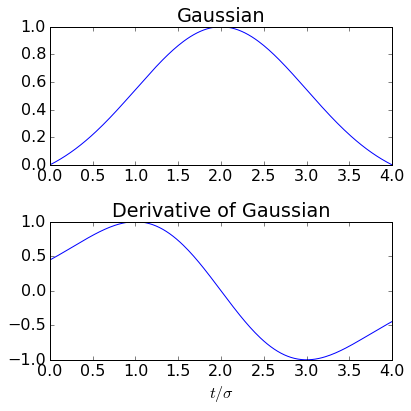

In [5]:
tList = np.linspace(0, cutoff, 201)
plt.figure(figsize=(6, 6))
plt.subplot(211)
plt.plot(tList/sigma, gaussian(tList, args=None))
plt.title('Gaussian')
plt.subplot(212)
plt.plot(tList/sigma, dgaussian(tList, args=None))
plt.title('Derivative of Gaussian')
plt.xlabel(r'$t/\sigma$')

plt.tight_layout()

## Functions
The following function uses the **propagator** method in QuTiP to calculate the unitary matrix $U$
caused by the application of a pulse. The **time dependent** part of the Hamiltonian is passed as a list in the form
`H = [H0, [operator, function]]`, where `operator` is the drive (e.g., $a+a^\dagger$) and `function` describes its time dependence (e.g., Gaussian).

For a pulse with gaussian in inphase and drag in quadrature, we have `H = [H0, [(a+adag), gaussian], [1j*(a-adag), dgaussian]]`.

In [6]:
def rabi(args):
    """
    Return the unitary matrix for the given amp and dragamp
    """
    amp = args[0]
    dragamp = args[1]
    H = [H0, [amp*(a+adag), gaussian], [dragamp*1j*(a-adag), dgaussian]]
    return qt.propagator(H, t=cutoff, c_op_list=[], args={})


def tuneAmp(args, N):
    """
    Use pulse train to tune amp
    """
    amp = args[0]
    dragamp = args[1]
    H = [H0, [amp*(a+adag), gaussian], [dragamp*1j*(a-adag), dgaussian]]
    U = qt.propagator(H, t=cutoff, c_op_list=[], args={})
    # apply pulse train (X90*X90)^n to (|0>+|1>)/sqrt(2) and save <sz> for n from 1 to N
    psi0 = (qt.basis(3, 0) - 1j*qt.basis(3, 1))/np.sqrt(2)
    sz_exp = [qt.expect(sz01, psi0)]
    for ii in range(0, N):
        psi0 = U*U*psi0
        sz_exp.append(qt.expect(sz01, psi0))
    return sz_exp


def tuneDrag(args, N):
    """
    Use pulse train to tune dragamp
    """
    amp = args[0]
    dragamp = args[1]
    H1 = [H0, [amp*(a+adag), gaussian], [dragamp*1j*(a-adag), dgaussian]]
    U1 = qt.propagator(H1, t=cutoff, c_op_list=[], args={})
    H2 = [H0, [-amp*(a+adag), gaussian], [-dragamp*1j*(a-adag), dgaussian]]
    U2 = qt.propagator(H2, t=cutoff, c_op_list=[], args={})
    psi0 = (qt.basis(3, 0) - 1j*qt.basis(3, 1))/np.sqrt(2)
    sz_exp = [qt.expect(sz01, psi0)]
    # apply pulse train (X90*X-90)^n to (|0>+|1>)/sqrt(2) and save <sz> for n from 1 to N
    for ii in range(0, N):
        psi0 = U1*U2*psi0
        sz_exp.append(qt.expect(sz01, psi0))
    return sz_exp

## Rough tuning inphase amplitude using Rabi

In [7]:
# Sweep inphase amplitude
ampList = np.linspace(0, 100, 101)
# No DRAG
dragamp = 0.0
# zip two lists and feed to parallel_map
argList = list(zip(ampList, np.repeat(dragamp, len(ampList))))
# Calculate the propagator for each amplitude
UList = qt.parallel_map(rabi, argList, progress_bar=True)
psi0 = qt.basis(3, 0)
# Apply each progagator the get the final state
szList = np.real(qt.expect(sz01, UList*psi0))

10.9%. Run time:   1.48s. Est. time left: 00:00:00:12
20.8%. Run time:   3.12s. Est. time left: 00:00:00:11
30.7%. Run time:   4.43s. Est. time left: 00:00:00:10
40.6%. Run time:   6.16s. Est. time left: 00:00:00:09
50.5%. Run time:   7.42s. Est. time left: 00:00:00:07
60.4%. Run time:   9.05s. Est. time left: 00:00:00:05
70.3%. Run time:  10.28s. Est. time left: 00:00:00:04
80.2%. Run time:  11.91s. Est. time left: 00:00:00:02
90.1%. Run time:  13.24s. Est. time left: 00:00:00:01
100.0%. Run time:  14.55s. Est. time left: 00:00:00:00
Total run time:  14.65s


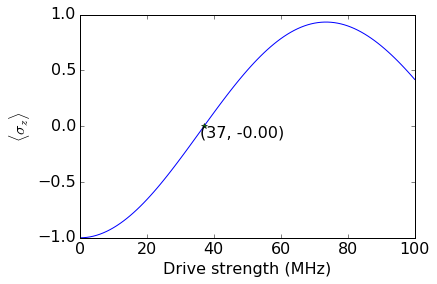

Drive strength for $\pi/2$ gate is 37.0.

In [8]:
# Select the amplitude that gives the smallest |<sz>| 
index = np.argmin(np.abs(szList))
ampRough = ampList[index]
plt.figure()
plt.plot(ampList, szList)
plt.plot(ampRough, szList[index], '*')
plt.text(ampRough-1, szList[index]-0.1,
         '(%.0f, %.2f)' % (ampRough, szList[index]))
plt.xlabel('Drive strength (MHz)')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.show()
display(Markdown(r'Drive strength for $\pi/2$ gate is %.1f.' % ampRough))

## Fine tuning inphase amplitude using pulse train $(X_{\pi/2}X_{\pi/2})^NX_{\pi/2}$

In [9]:
ampTune = np.linspace(ampRough - 1.0, ampRough + 1.0, 101)
N = 7
argList = list(zip(ampTune, np.repeat(dragamp, len(ampTune))))
results = np.array(qt.parallel_map(tuneAmp, argList, task_args=(N,), progress_bar=True))

10.9%. Run time:   1.94s. Est. time left: 00:00:00:15
20.8%. Run time:   3.80s. Est. time left: 00:00:00:14
30.7%. Run time:   5.09s. Est. time left: 00:00:00:11
40.6%. Run time:   6.89s. Est. time left: 00:00:00:10
50.5%. Run time:   8.25s. Est. time left: 00:00:00:08
60.4%. Run time:  10.00s. Est. time left: 00:00:00:06
70.3%. Run time:  11.43s. Est. time left: 00:00:00:04
80.2%. Run time:  13.12s. Est. time left: 00:00:00:03
90.1%. Run time:  14.59s. Est. time left: 00:00:00:01
100.0%. Run time:  16.02s. Est. time left: 00:00:00:00
Total run time:  16.05s


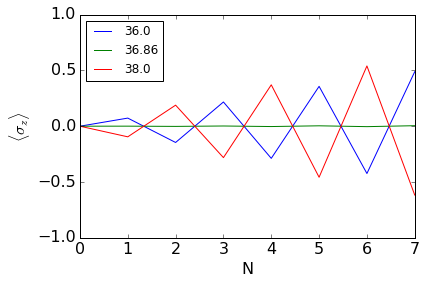

Drive strength for $\pi/2$ gate is 36.86.

In [10]:
index = np.argmin(np.abs(results[:, -1]))
ampFine = ampTune[index]
plt.figure()
plt.plot(range(0, N+1), np.real(results[0, :]))
plt.plot(range(0, N+1), np.real(results[index, :]))
plt.plot(range(0, N+1), np.real(results[-1, :]))
plt.ylim(-1, 1)
plt.xlabel('N')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.legend([ampTune[0], ampFine, ampTune[-1]], fontsize=12, loc='best')
plt.show()
display(Markdown(r'Drive strength for $\pi/2$ gate is %.2f.' % ampFine))

## DRAG error
So far we have only tuned the inphase drive and kept the quadrature drive as zero. To visualize DRAG error, we apply the $X_{\pi/2}$ gate to qubit ground state and plot the final state on the Bloch sphere.

<IPython.core.display.Latex object>

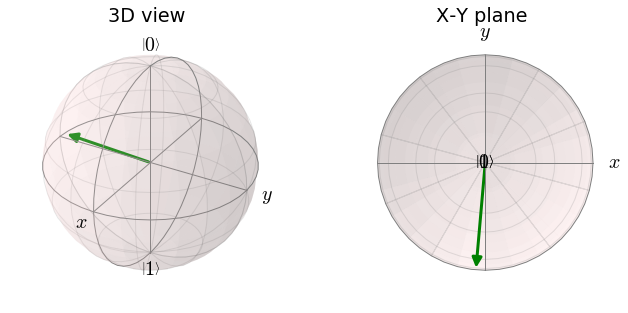

In [11]:
psi = rabi((ampFine, 0.0)) * qt.basis(3, 0)
bvec = [qt.expect(sx01, psi), qt.expect(sy01, psi), qt.expect(sz01, psi)]
fig = plt.figure(figsize=(11, 5))
ax1 = plt.subplot(121, projection='3d')
bs1 = qt.Bloch(fig=fig, axes=ax1)
bs1.add_vectors(bvec)
bs1.make_sphere()
plt.title('3D view\n')

ax2 = plt.subplot(122, projection='3d')
ax2.view_init(elev=90, azim=180)
bs2 = qt.Bloch(fig=fig, axes=ax2)
bs2.add_vectors(bvec)
bs2.make_sphere()
plt.title('X-Y plane\n')
display(Latex(r'$|\psi\rangle=\begin{pmatrix}\
                %f + %f\mathrm{i}, \\ %f + %f\mathrm{i} \end{pmatrix}$'
              % (np.real(psi[0]), np.imag(psi[0]), np.real(psi[1]), np.imag(psi[1]))))

There is extra $Z$ rotation compared to an ideal $X_{\pi/2}$ gate, which is due to the existence of higher energy levels. To correct this error, the DRAG scheme uses another pulse that has the shape of derivative of in-phase as the quadrature drive.

## Rough tuning quadrature amplitude using Rabi

In [12]:
# Sweep quadrature amplitude
dragList = np.linspace(-10, 10, 101)
# Keep inphase amp as the tuned value
argList = list(zip(np.repeat(ampFine, len(dragList)), dragList))
UList = qt.parallel_map(rabi, argList, progress_bar=True)
psi0 = qt.basis(3, 0)
sxList = np.real(qt.expect(sx01, UList*psi0))

10.9%. Run time:   1.56s. Est. time left: 00:00:00:12
20.8%. Run time:   3.05s. Est. time left: 00:00:00:11
30.7%. Run time:   4.29s. Est. time left: 00:00:00:09
40.6%. Run time:   5.88s. Est. time left: 00:00:00:08
50.5%. Run time:   7.48s. Est. time left: 00:00:00:07
60.4%. Run time:   9.19s. Est. time left: 00:00:00:06
70.3%. Run time:  10.85s. Est. time left: 00:00:00:04
80.2%. Run time:  12.32s. Est. time left: 00:00:00:03
90.1%. Run time:  13.49s. Est. time left: 00:00:00:01
100.0%. Run time:  14.83s. Est. time left: 00:00:00:00
Total run time:  14.86s


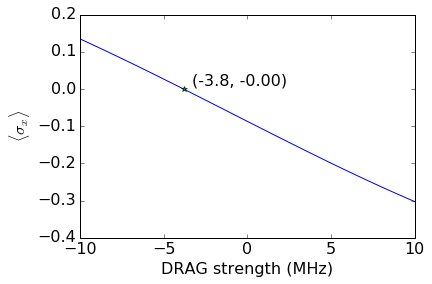

DRAG strength for $\pi/2$ gate is -3.80.

In [13]:
# Select the amplitude that gives the smallest |<sx>| 
index = np.argmin(np.abs(sxList))
dragRough = dragList[index]
plt.figure()
plt.plot(dragList, sxList)
plt.plot(dragRough, sxList[index], '*')
plt.text(dragRough+0.5, sxList[index]+0.01, '(%.1f, %.2f)' % (dragRough, sxList[index]))
plt.xlabel('DRAG strength (MHz)')
plt.ylabel(r'$\langle\sigma_x\rangle$')
plt.show()
display(Markdown(r'DRAG strength for $\pi/2$ gate is %.2f.' % dragRough))

## Fine tuning quadrature amplitude using pulse train $(X_{\pi/2}X_{-\pi/2})^NX_{\pi/2}$

In [14]:
dragTune = np.linspace(dragRough - 0.2, dragRough + 0.2, 101)
N = 7
argList = list(zip(np.repeat(ampFine, len(dragTune)), dragTune))
szList = np.array(qt.parallel_map(tuneDrag, argList, task_args=(N,),
                                  progress_bar=True))

10.9%. Run time:   3.81s. Est. time left: 00:00:00:31
20.8%. Run time:   7.02s. Est. time left: 00:00:00:26
30.7%. Run time:  10.08s. Est. time left: 00:00:00:22
40.6%. Run time:  13.29s. Est. time left: 00:00:00:19
50.5%. Run time:  15.99s. Est. time left: 00:00:00:15
60.4%. Run time:  19.13s. Est. time left: 00:00:00:12
70.3%. Run time:  21.66s. Est. time left: 00:00:00:09
80.2%. Run time:  25.19s. Est. time left: 00:00:00:06
90.1%. Run time:  27.50s. Est. time left: 00:00:00:03
100.0%. Run time:  30.57s. Est. time left: 00:00:00:00
Total run time:  30.60s


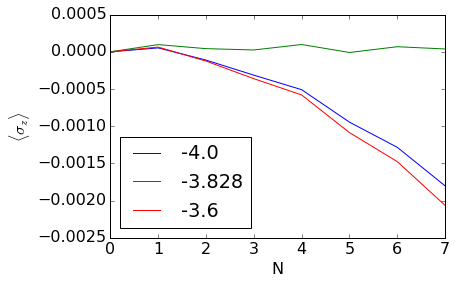

DRAG strength for $\pi/2$ gate is -3.828.

In [15]:
index = np.argmin(np.mean(np.abs(results), axis=1))
dragFine = dragTune[index]
plt.figure()
plt.plot(range(0, N+1), np.real(szList[0, :]))
plt.plot(range(0, N+1), np.real(szList[index, :]))
plt.plot(range(0, N+1), np.real(szList[-1, :]))
plt.xlabel('N')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.legend([dragTune[0], dragFine, dragTune[-1]], loc='best')
plt.show()
display(Markdown(r'DRAG strength for $\pi/2$ gate is %.3f.' % dragFine))

## Final result

<IPython.core.display.Latex object>

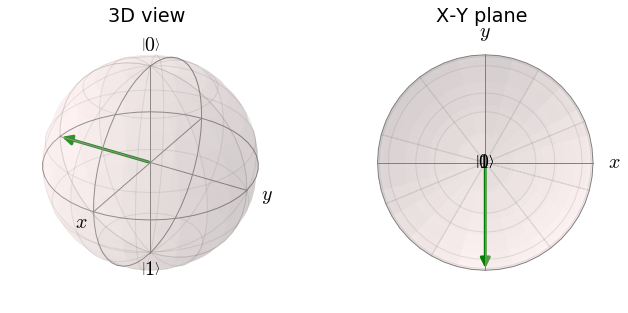

In [16]:
psi = rabi((ampFine, dragFine)) * qt.basis(3, 0)
bvec = [qt.expect(sx01, psi), qt.expect(sy01, psi), qt.expect(sz01, psi)]
fig = plt.figure(figsize=(11, 5))
ax1 = plt.subplot(121, projection='3d')
bs1 = qt.Bloch(fig=fig, axes=ax1)
bs1.add_vectors(bvec)
bs1.make_sphere()
plt.title('3D view\n')

ax2 = plt.subplot(122, projection='3d')
ax2.view_init(elev=90, azim=180)
bs2 = qt.Bloch(fig=fig, axes=ax2)
bs2.add_vectors(bvec)
bs2.make_sphere()
plt.title('X-Y plane\n')
display(Latex(r'$|\psi\rangle=\begin{pmatrix}\
                %f + %f\mathrm{i}, \\ %f + %f\mathrm{i} \end{pmatrix}$'
              % (np.real(psi[0]), np.imag(psi[0]), np.real(psi[1]), np.imag(psi[1]))))

In [17]:
from qutip.ipynbtools import version_table
version_table()

/home/gengyan/anaconda3/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


Software,Version
QuTiP,3.2.0.dev-c209b67
Numpy,1.11.1
SciPy,0.17.1
matplotlib,1.5.1
Cython,0.24.1
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,5.0.0
Python,"3.5.2 |Continuum Analytics, Inc.| (default, Jul 2 2016, 17:53:06) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
OS,posix [linux]
